In [1]:
!pip install tensorflow --upgrade --quiet
!yes | apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-transform 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<2.10,>=1.15.5, but you have tensorflow 2.11.0 which is incompatible.
tensorflow-io 0.21.0 requires tensorflow<2.7.0,>=2.6.0, but you have tensorflow 2.11.0 which is incompatible.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, but you have tensorflow-io-gcs-filesystem 0.29.0 which is incompatible.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8
1 upgraded, 0 newly installed, 1 to remove and 91 not upgraded.
Need to get 430 MB of archives.
After this operation, 2506 MB

In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')



2022-12-24 13:07:30.555460: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-24 13:07:31.673406: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-12-24 13:07:31.673664: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Co

Functions used in this model

In [3]:
#Getting both training data and testing data images
def get_data(dataset,mode):
    image_size = (100, 100)
    batch = 32
    if mode=='train':
        sbst='training'
        vs=.003
    if mode=='test':
        sbst='validation'
        vs=.99
    data = keras.preprocessing.image_dataset_from_directory(
        dataset,
        validation_split=vs,
        subset=sbst,
        seed=42,
        image_size=image_size,
        batch_size=batch,
        label_mode='categorical'
    )
    return data


#To display the sample images
def display_samples(dataset, n_samples, classes_name):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(n_samples):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(classes_name[np.argmax(labels[i])])
            plt.axis("off")
            
            
 #Data Augmentation function with visualization             
def data_augumentation(data,visualize=False):
    resize = tf.keras.layers.Resizing(128, 128)
    height = tf.keras.layers.RandomHeight(0.3)
    width = tf.keras.layers.RandomWidth(0.3)
    zoom = tf.keras.layers.RandomZoom(0.3) 
    flip = tf.keras.layers.RandomFlip("horizontal_and_vertical")
    rotate = tf.keras.layers.RandomRotation(0.2)
    crop = tf.keras.layers.RandomCrop(64, 64)
    translation = tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2)
    contrast = tf.keras.layers.RandomContrast(0.2)
    if visualize==False:
        for images, labels in data.take(1):
            for i in range(3):
                clear_output(wait=True)
                images[i].numpy().astype("uint8")
                # resize
                resize(images[i]).numpy().astype("uint8")
                # height
                height(images[i]).numpy().astype("uint8")
                # width
                width(images[i]).numpy().astype("uint8")
                # zoom
                zoom(images[i]).numpy().astype("uint8")
                # flip
                flip(images[i]).numpy().astype("uint8")
                # crop
                crop(images[i]).numpy().astype("uint8")
                # translation
                translation(images[i]).numpy().astype("uint8")
                # rotate
                rotate(images[i]).numpy().astype("uint8")
                # contrast
                contrast(images[i]).numpy().astype("uint8")
    if visualize==True:
        fig, ax = plt.subplots(5, 5, figsize=(6,14))
        for images, labels in train.take(1):
            for i in range(5):
                ax[0][i].imshow(images[i].numpy().astype("uint8"))
                ax[0][i].set_title("original")
                # resize
                ax[1][i].imshow(resize(images[i]).numpy().astype("uint8"))
                ax[1][i].set_title("resize")
                # height
                ax[2][i].imshow(height(images[i]).numpy().astype("uint8"))
                ax[2][i].set_title("height")
                # width
                ax[3][i].imshow(width(images[i]).numpy().astype("uint8"))
                ax[3][i].set_title("width")
                # zoom
                ax[4][i].imshow(zoom(images[i]).numpy().astype("uint8"))
                ax[4][i].set_title("zoom")

                # flip
                ax[1][i].imshow(flip(images[i]).numpy().astype("uint8"))
                ax[1][i].set_title("flip")
                # crop
                ax[2][i].imshow(crop(images[i]).numpy().astype("uint8"))
                ax[2][i].set_title("crop")
                # translation
                ax[3][i].imshow(translation(images[i]).numpy().astype("uint8"))
                ax[3][i].set_title("translation")
                # rotate
                ax[4][i].imshow(rotate(images[i]).numpy().astype("uint8"))
                ax[4][i].set_title("rotate")

                # contrast
                ax[2][i].imshow(contrast(images[i]).numpy().astype("uint8"))
                ax[2][i].set_title("contrast")
        plt.show()


# Load dataset

In [4]:
image_size = (100, 100)
train_path='/kaggle/input/chess-dataset/Chess/Train/'
test_path='/kaggle/input/chess-dataset/Chess/Test/'

In [5]:
train=get_data(train_path,'train')
validation=get_data(test_path,'test')

Found 476 files belonging to 6 classes.
Using 475 files for training.
Found 86 files belonging to 6 classes.
Using 85 files for validation.


### Displaying sample images of train data

--------*-----train-----*---------


2022-12-24 13:07:37.896645: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 20348919 exceeds 10% of free system memory.
2022-12-24 13:07:38.576635: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 106632000 exceeds 10% of free system memory.
2022-12-24 13:07:39.098673: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 18750000 exceeds 10% of free system memory.
2022-12-24 13:07:39.128894: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 27367131 exceeds 10% of free system memory.
2022-12-24 13:07:39.256240: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 48000000 exceeds 10% of free system memory.


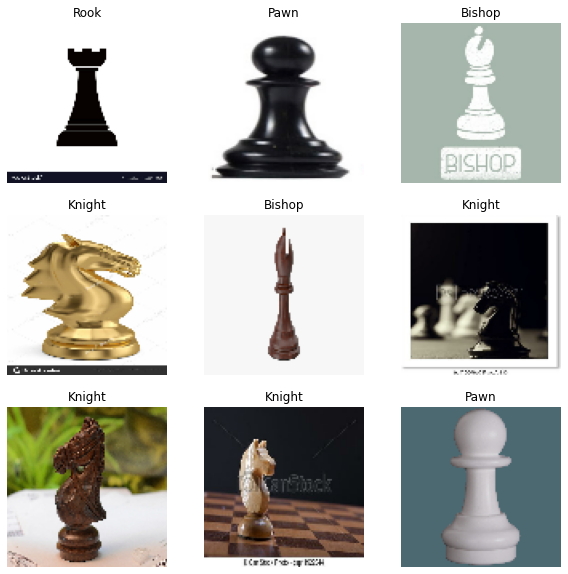

In [6]:
print("--------*-----train-----*---------")
display_samples(train, 9, train.class_names)

### Displaying sample images of test/validation data

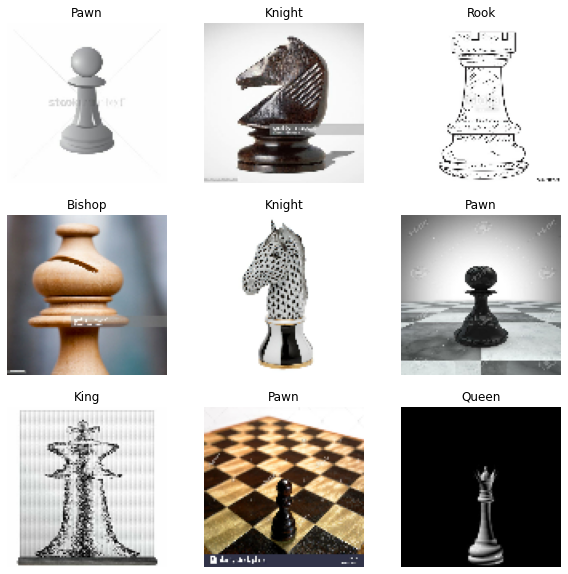

In [7]:
display_samples(validation, 9, validation.class_names)

In [8]:
class_names = train.class_names
labels = np.array([])
for _, label in train:
    clear_output(wait=True)
    labels = np.concatenate((labels, np.argmax(label, axis=-1)))
_, counts = np.unique(labels, return_counts=True)

In [9]:
total = counts.sum()
print("Frequency of each piece")
for i in range(len(counts)):
    print(f'{class_names[i]}: {counts[i]}({counts[i] / total:.2f}%)')

Frequency of each piece
Bishop: 74(0.16%)
King: 63(0.13%)
Knight: 89(0.19%)
Pawn: 90(0.19%)
Queen: 66(0.14%)
Rook: 93(0.20%)


# Building CNN model

In [10]:
input_shape=(image_size[0], image_size[1], 3)
reg = keras.regularizers.l2(0.0005)
model1 = keras.Sequential()
model1.add(Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=image_size + (3,), kernel_regularizer=reg))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Conv2D(64, (3, 3), padding="same", activation="relu", kernel_regularizer=reg))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Flatten())
model1.add(Dropout(0.5))
model1.add(Dense(len(train.class_names), activation='softmax'))
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 40000)             0         
                                                                 
 dropout (Dropout)           (None, 40000)             0

In [11]:
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
callbacks = [EarlyStopping(monitor='val_acc', patience=5, verbose=2), ModelCheckpoint('checkpoints/weights.{epoch:02d}.hdf5', save_best_only=True), TensorBoard('~/notebooks/logs',
                                                                                      write_graph=True, write_grads=True, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)]



In [12]:
batch_size = 128
epochs = 15

model1.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model1.fit(
    train,
    epochs=epochs,
    validation_data=validation,
    callbacks=callbacks)

Epoch 1/15


2022-12-24 13:07:51.665729: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-12-24 13:07:53.422535: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-12-24 13:07:53.575205: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-addr

15/15 [==============================] - 9s 124ms/step - loss: 236.8632 - accuracy: 0.1768 - val_loss: 3.2893 - val_accuracy: 0.1882
Epoch 2/15
15/15 [==============================] - 3s 111ms/step - loss: 2.1979 - accuracy: 0.2758 - val_loss: 2.2119 - val_accuracy: 0.1412
Epoch 3/15
15/15 [==============================] - 4s 112ms/step - loss: 1.5187 - accuracy: 0.3305 - val_loss: 2.0633 - val_accuracy: 0.2000
Epoch 4/15
15/15 [==============================] - 3s 109ms/step - loss: 1.3913 - accuracy: 0.4021 - val_loss: 2.1888 - val_accuracy: 0.1176
Epoch 5/15
15/15 [==============================] - 3s 107ms/step - loss: 1.2746 - accuracy: 0.4611 - val_loss: 2.5161 - val_accuracy: 0.1647
Epoch 6/15
15/15 [==============================] - 3s 109ms/step - loss: 1.1165 - accuracy: 0.5284 - val_loss: 2.8050 - val_accuracy: 0.2118
Epoch 7/15
15/15 [==============================] - 3s 109ms/step - loss: 1.0218 - accuracy: 0.5895 - val_loss: 3.0357 - val_accuracy: 0.2353
Epoch 8/15
15/1

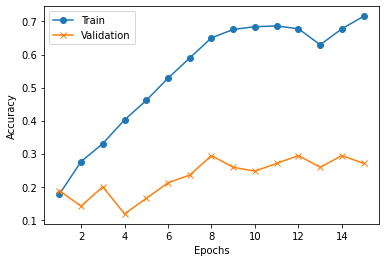

In [13]:
epochs_range = [i+1 for i in range(epochs)]
plt.plot(epochs_range, model1.history.history['accuracy'], '-o', label='Train')
plt.plot(epochs_range, model1.history.history['val_accuracy'], '-x',label='Validation')

plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plt.legend();

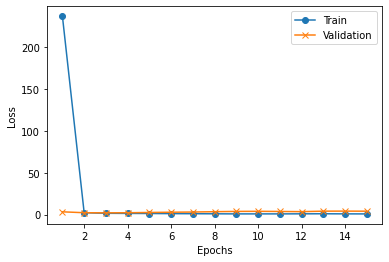

In [14]:
epochs_range = [i+1 for i in range(epochs)]
plt.plot(epochs_range, model1.history.history['loss'], '-o', label='Train')
plt.plot(epochs_range, model1.history.history['val_loss'], '-x',label='Validation')

plt.ylabel('Loss')
plt.xlabel('Epochs')

plt.legend();

Conclusion:  Hence, we were able to build a CNN model with less than 300,000 parameters and train it and fit the model. The above model  is able to predict the chess coins type  with 70% accuracy in traing data and 27% in testing data  when  different types of chess coins were tested for prediction. This model will work with much better accuracy when trained with more appropriate images in the dataset.

The results of this model is not satisfied. With a limited depth (one convolutional layer,one max pooling layer and one fully connected layer), and just around 15 epochs, we were able to get 70% accuracy on the train set and only 27% in test set.But from the graphs we can infer that the loss is very similar in both train and validation dataset. Our model has 259398 trainable parameters and runs 1 epoch in around 45 seconds on a GPU T4 x2.  With some of the additional techniques , we can try to boost our own test score for our model further.

# Improve the baseline model performance and save the weights of improved model 


## Data Augmentation

A popular method to boost the performance of a network for computer vision tasks is to add data augmentation. By using data augmentation,during training time, we can increase the size of the training set. As aconsequence, we can makeyour model more robust to slight variations in the training data.

In [15]:
data_augumentation(train)
data_augumentation(validation)

### Creating the model on a dataset after Augmentation:

In [ ]:
input_shape = (image_size[0], image_size[1], 3)
reg = keras.regularizers.l2(0.0005)

model = keras.Sequential()


model.add(Conv2D(64, (3, 3), padding="same", activation="relu", input_shape=image_size + (3,), kernel_regularizer=reg))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding="same", activation="relu", kernel_regularizer=reg))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), padding="same", activation="relu", kernel_regularizer=reg))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(len(train.class_names), activation='softmax'))


model.summary()

### Using callbacks to save the best model weights

In [17]:
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
callbacks = [EarlyStopping(monitor='val_acc', patience=5, verbose=2), ModelCheckpoint('checkpoints/weights.{epoch:02d}.hdf5', save_best_only=True), TensorBoard('~/notebooks/logs',
                                                                                      write_graph=True, write_grads=True, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)]



In [18]:
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)



In [19]:
 
epochs = 15
print("========================\n",epochs,"\n===========================")
model.fit(
    train,
    epochs=epochs,
    validation_data=validation,
    callbacks=callbacks,
);


 15 
Epoch 1/15


2022-12-24 13:08:57.761889: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2022-12-24 13:09:00.074842: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-12-24 13:09:00.292819: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often suff

 1/15 [=>............................] - ETA: 1:18 - loss: 2.8535 - accuracy: 0.1875

2022-12-24 13:09:01.866345: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


15/15 [==============================] - 9s 210ms/step - loss: 2.8949 - accuracy: 0.2147 - val_loss: 49.0776 - val_accuracy: 0.1529
Epoch 2/15
15/15 [==============================] - 4s 142ms/step - loss: 2.2956 - accuracy: 0.2779 - val_loss: 12.3978 - val_accuracy: 0.2235
Epoch 3/15
15/15 [==============================] - 4s 139ms/step - loss: 1.9723 - accuracy: 0.3495 - val_loss: 7.7173 - val_accuracy: 0.2706
Epoch 4/15
15/15 [==============================] - 4s 141ms/step - loss: 2.0892 - accuracy: 0.3432 - val_loss: 5.9248 - val_accuracy: 0.2471
Epoch 5/15
15/15 [==============================] - 4s 138ms/step - loss: 1.7714 - accuracy: 0.4232 - val_loss: 2.8494 - val_accuracy: 0.3412
Epoch 6/15
15/15 [==============================] - 4s 127ms/step - loss: 1.5240 - accuracy: 0.5095 - val_loss: 3.1718 - val_accuracy: 0.3176
Epoch 7/15
15/15 [==============================] - 4s 137ms/step - loss: 1.4722 - accuracy: 0.5305 - val_loss: 1.9796 - val_accuracy: 0.4235
Epoch 8/15
15/1

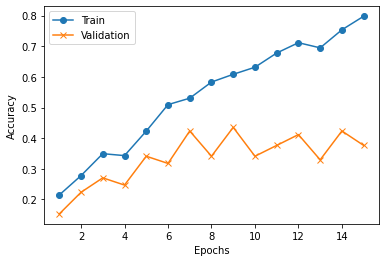

In [20]:
epochs_range = [i+1 for i in range(epochs)]
plt.plot(epochs_range, model.history.history['accuracy'], '-o', label='Train')
plt.plot(epochs_range, model.history.history['val_accuracy'], '-x',label='Validation')

plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plt.legend();

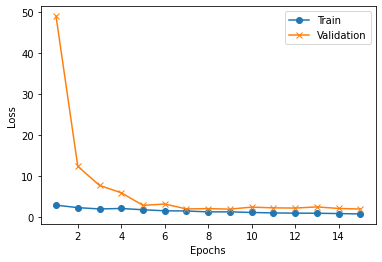

In [21]:
epochs_range = [i+1 for i in range(epochs)]
plt.plot(epochs_range, model.history.history['loss'], '-o', label='Train')
plt.plot(epochs_range, model.history.history['val_loss'], '-x',label='Validation')

plt.ylabel('Loss')
plt.xlabel('Epochs')

plt.legend();

From the above graphs we can infer that the training dataset accuracy increases when increasing the number of epochs and testing data accuracy remains changing.
At 15 epochs the training data is nearly 80 percent whereas the testing data has only 37% of accuracy, which clearly shows that the dataset is not good and it leads to overfitting though we have done different augmentation techniques.

The loss remains more similar after 4 epochs both in training and testing datasets.

#### Original images and data augmentation images

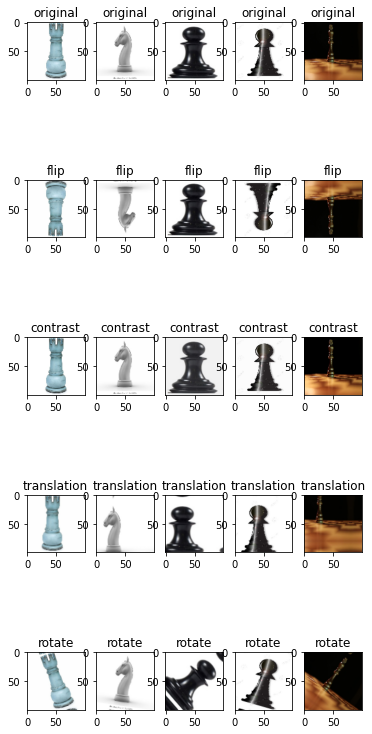

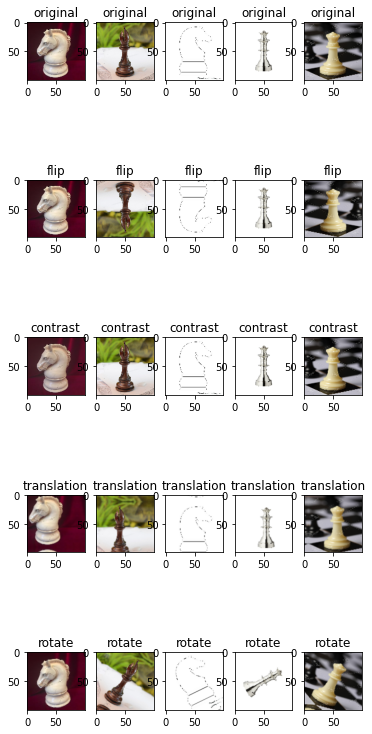

In [22]:
data_augumentation(train,True)
data_augumentation(validation,True)